<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [4]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [5]:
df.isnull().sum()

comment    0
topic      1
dtype: int64

In [6]:
# Drop na
df.dropna(axis=0, inplace=True)

In [7]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
application                   190
others                        188
People                        113
service                       105
Process                        69
charges                        47
people                         37
PEOPLE                         32
product                        20
Product                        13
PROCESS                         6
process                         4
research                        3
Name: topic, dtype: int64

In [8]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

In [9]:
df.topic.unique()

array(['service', 'application (web/app)', 'others',
       'charges(bro./dp/lpc etc.)', 'process', 'people', 'product',
       'application', 'charges', 'research'], dtype=object)

In [10]:
topic_dic = {'application (web/app)': 'application',  'charges(bro./dp/lpc etc.)': 'charges', 'service':'service'
, 'others':'others', 'process':'process', 'people':'people', 'product':'product', 'research':'research'}

In [11]:
df['topic'] = df['topic'].apply(lambda x: topic_dic[x] if x in topic_dic else x)

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='count', ylabel='topic'>

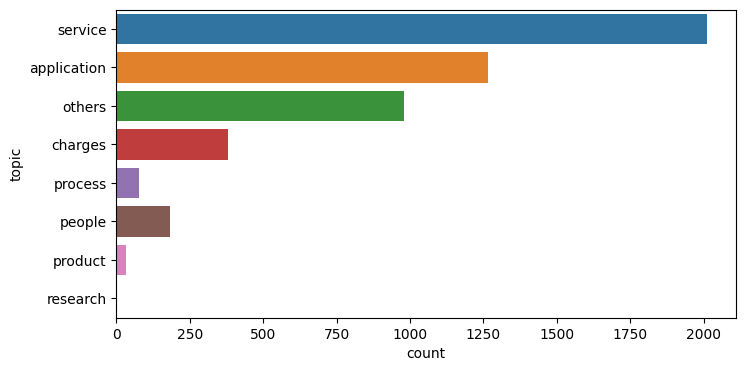

In [12]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [13]:
# Preprocessing

In [14]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df = df[df['comment'].apply(lambda x: not isinstance(x, float))]

df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [15]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    # if lst_stopwords is not None:
    #     lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [16]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.remove('no')
lst_stopwords.remove('not')

In [17]:
df["x"] = df["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=lst_stopwords))
# df['x'] = df['comment']
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries where kotak is at disadvantageous pos...,service
1,1) same-day money deduction even if we have ma...,application,same day money deduction even if we have margi...,application
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application,worst website trading,application
4,"no technical support at real time, application...",service,no technical support at real time application ...,service
5,need knowledge and experience person,service,need knowledge and experience person,service
6,please revisit my brokerage and deemat charges...,charges,please revisit my brokerage and deemat charges...,charges
7,iâm waiting for resolution or a meeting with...,service,i m waiting for resolution or a meeting with m...,service
8,i dint interacted so my rating may be a bias b...,service,i dint interacted so my rating may be a bias b...,service
9,no issues with the rm,service,no issues with the rm,service


In [18]:
df = df[['x', 'y']]

In [19]:
df.isnull().sum()

x    0
y    0
dtype: int64

In [20]:
# Prefixing each row of the category column with '__label__'
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + x)

In [21]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.30, stratify=df['y'], random_state=324)

In [22]:
import csv

In [23]:
pip install fasttext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393301 sha256=c86f24b37709f6a333b9b8f40bccd8898281013c7e931eae8ee6c2568c77997c
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [24]:
import fasttext
# Saving the CSV file as a text file to train/test the classifier
df_train[['y', 'x']].to_csv('train.txt',
                                          index = False,
                                          sep = ' ',
                                          header = None,
                                          quoting = csv.QUOTE_NONE,
                                          quotechar = "",
                                          escapechar = " ")

df_test[['y', 'x']].to_csv('test.txt',
                                     index = False,
                                     sep = ' ',
                                     header = None,
                                     quoting = csv.QUOTE_NONE,
                                     quotechar = "",
                                     escapechar = " ")


# Training the fastText classifier
model = fasttext.train_supervised('train.txt',lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50)

# Evaluating performance on the entire test file
model.test('test.txt')

# Predicting on a single input
# model.predict(ds.iloc[2, 0])

# Save the trained model
#model.save_model('model.bin')

(1479, 0.8079783637592968, 0.8079783637592968)

In [25]:
model.test('train.txt')
model.test('test.txt')

(3450, 0.9924637681159421, 0.9924637681159421)

(1479, 0.8079783637592968, 0.8079783637592968)

In [26]:
df_test_pred = df_test
df_test_pred['y_pred'] = df_test_pred['x'].apply(model.predict)
df_test_pred['y_pred']=df_test_pred['y_pred'].str[0:1]
df_test_pred['y_pred'] = df_test_pred['y_pred'].astype(str)
df_test_pred['y_pred'] = df_test_pred['y_pred'].str[12:-5]
df_test_pred['y'] = df_test_pred['y'].str[9:]

In [27]:
df_pred = df
df_pred['y_pred'] = df_pred['x'].apply(model.predict)
df_pred['y_pred'] = df_pred['y_pred'].str[0:1]
df_pred['y_pred'] = df_pred['y_pred'].astype(str)
df_pred['y_pred'] = df_pred['y_pred'].str[12:-5]
df_pred['y'] = df_pred['y'].str[9:]

In [28]:
df

,x,y,y_pred
0,querries where kotak is at disadvantageous pos...,service,service
1,same day money deduction even if we have margi...,application,application
2,ndejjejdjx,others,others
3,worst website trading,application,application
4,no technical support at real time application ...,service,service
...,...,...,...
4924,your pr offiecer in not good and my call not a...,people,people
4925,your services are very good and i am satisfied...,service,service
4926,your staff does not give service no one is the...,service,service
4927,your trading platform is excellent you provide...,product,product


In [29]:
# Dict for classes
df_pred['category_id'] = df_pred['y'].factorize()[0]
category_id_df = df_pred[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [30]:
df_test_pred['category_id'] = df_test_pred['y'].map(category_to_id)
df_test_pred['category_id_pred'] = df_test_pred['y_pred'].map(category_to_id)
df_pred['category_id_pred'] = df_pred['y_pred'].map(category_to_id)

In [31]:
df_test_pred[df_test_pred['category_id_pred'].isnull()]

,x,y,y_pred,category_id,category_id_pred


In [32]:
df_test_pred.y_pred.unique()

array(['service', 'charges', 'application', 'people', 'others', 'process',
       'product'], dtype=object)

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

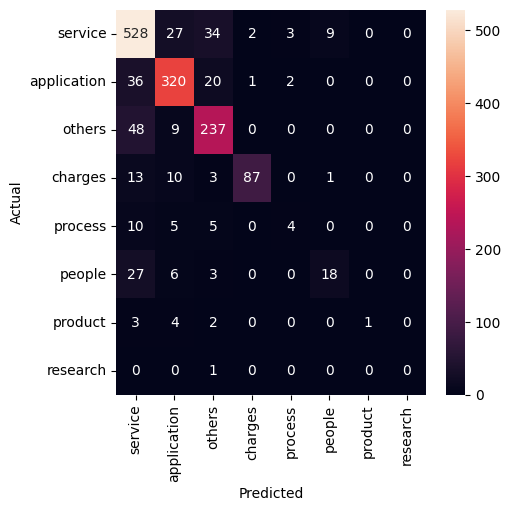

In [33]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test_pred['category_id'], df_test_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [34]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(df_test_pred['category_id'], df_test_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.79      0.88      0.83       603
 application       0.84      0.84      0.84       379
      others       0.78      0.81      0.79       294
     charges       0.97      0.76      0.85       114
     process       0.44      0.17      0.24        24
      people       0.64      0.33      0.44        54
     product       1.00      0.10      0.18        10
    research       0.00      0.00      0.00         1

    accuracy                           0.81      1479
   macro avg       0.68      0.49      0.52      1479
weighted avg       0.81      0.81      0.80      1479



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

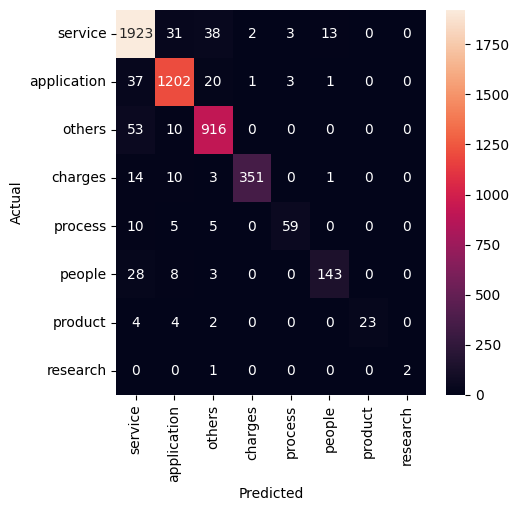

In [35]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_pred['category_id'], df_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [36]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(df_pred['category_id'], df_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.93      0.96      0.94      2010
 application       0.95      0.95      0.95      1264
      others       0.93      0.94      0.93       979
     charges       0.99      0.93      0.96       379
     process       0.91      0.75      0.82        79
      people       0.91      0.79      0.84       182
     product       1.00      0.70      0.82        33
    research       1.00      0.67      0.80         3

    accuracy                           0.94      4929
   macro avg       0.95      0.83      0.88      4929
weighted avg       0.94      0.94      0.94      4929



In [37]:
res = pd.DataFrame()
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            # print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            temp = df_pred.query(f' (category_id == {actual}) & (category_id_pred == {predicted})')[['x']]
            temp['y'] = id_to_category[actual]
            temp['y_pred'] = id_to_category[predicted]
            # print('')
            res = pd.concat([res,temp])

In [38]:
from google.colab import data_table
data_table.DataTable(res, include_index=False, num_rows_per_page=10)

,x,y,y_pred
213,i am getting very bad experience with your tra...,application,service
823,only researched equity stock are correct in re...,application,service
832,please improve traffic related issue there is ...,application,service
865,it is suggested that team who files the reply ...,application,service
1049,try to solve technical issue within hours or b...,application,service
...,...,...,...
2303,the dealer did not resolve my queries rather i...,service,people
2312,not interested customer service sitting at cal...,service,people
2798,sorry to say they are unable to resolve my pro...,service,people
3330,please change my relationship manager they are...,service,people


In [39]:
from google.colab import data_table
data_table.DataTable(df_pred.query(' y != y_pred')[['x','y', 'y_pred']], include_index=False, num_rows_per_page=10)

,x,y,y_pred
41,still not solve my problems,service,others
96,slowly moving to zerodha,others,service
205,i like to start my trading so please request y...,application,others
213,i am getting very bad experience with your tra...,application,service
228,your app is not trustworthy customer care numb...,service,application
...,...,...,...
4883,very unprofessional behavior,people,others
4901,worst ever rd class everything,others,service
4904,worst organisation simply making money and mor...,product,service
4905,worst recommendation,research,others


In [40]:
# Testing on Apr May data

In [46]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/may_jun_jul_nps.csv"""
test = pd.read_csv(url, on_bad_lines='skip')

In [47]:
test.head()

,TYPE,MONTH,RATING,COMMENT-CUSTOMER,VOC
0,Detractor,APRIL,0,"0 is very high, it should be negative as ur s...",People
1,Passive,MAY,8,1. Website is quite slow- must be improved. 2...,WEB/APP
2,Detractor,MAY,4,1.Order execution refresh rate is slow. Improv...,WEB/APP
3,Detractor,MAY,0,3 rd clasd,not specified
4,Detractor,MAY,0,3 rd class,not specified


In [49]:
test.rename(columns ={'COMMENT-CUSTOMER':'comment', 'VOC': 'topic'}, inplace=True)

In [50]:
test.drop_duplicates(inplace=True)

In [51]:
test['topic'].unique()

array(['People', 'WEB/APP', 'not specified', 'Charges', 'product',
       'Service', 'process', 'others', 'reasearch', 'OTHERS',
       'Not Specified', 'Web/App', 'App/Product/Service', 'Process',
       'Product', 'Other', 'Research'], dtype=object)

In [ ]:
topic_dic = {'WEB/APP': 'application',  'Charges': 'charges', 'Service':'service'
, 'OTHERS':'others', 'not specified':'others', 'process':'process', 'People':'people', 'product':'product', 'reasearch':'research'}

In [ ]:
test['topic'] = test['topic'].map(topic_dic)

In [ ]:
test.head()

,comment,topic
0,"0 is very high, it should be negative as ur s...",people
1,1. Website is quite slow- must be improved. 2...,application
2,1.Order execution refresh rate is slow. Improv...,application
3,3 rd clasd,others
4,3 rd class,others


In [52]:
test["x"] = test["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=lst_stopwords))
# df['x'] = df['comment']
test['y'] = test['topic']
test.head(10)

,TYPE,MONTH,RATING,comment,topic,x,y
0,Detractor,APRIL,0,"0 is very high, it should be negative as ur s...",People,is very high it should be negative as ur staff...,People
1,Passive,MAY,8,1. Website is quite slow- must be improved. 2...,WEB/APP,website is quite slow must be improved a watch...,WEB/APP
2,Detractor,MAY,4,1.Order execution refresh rate is slow. Improv...,WEB/APP,order execution refresh rate is slow improveme...,WEB/APP
3,Detractor,MAY,0,3 rd clasd,not specified,rd clasd,not specified
4,Detractor,MAY,0,3 rd class,not specified,rd class,not specified
5,Detractor,MAY,3,मेने डीलर से कांटेक्ट करने की कोशिश की पर नहीं...,not specified,,not specified
6,Passive,JUNE,8,About brokerage,Charges,about brokerage,Charges
7,Detractor,MAY,0,Active BSE FO,product,active bse fo,product
8,Passive,JUNE,7,Actually aap is not properly work and delar di...,WEB/APP,actually aap is not properly work and delar di...,WEB/APP
9,Detractor,APRIL,6,Add order execution notification sound,WEB/APP,add order execution notification sound,WEB/APP


In [53]:
# Remove integer comments
test = test[test['x'].apply(lambda x: not isinstance(x, int))]
test.reset_index(drop=True, inplace=True)

#lower case
test['x'] = test['x'].str.lower()

In [54]:
test['y_pred'] = test['x'].apply(model.predict)
test['y_pred']=test['y_pred'].str[0:1]
test['y_pred'] = test['y_pred'].astype(str)
test['y_pred'] = test['y_pred'].str[12:-5]
test['y'] = test['y'].str[9:]

In [55]:
test.dropna(inplace=True)

In [56]:
word_dict = {
    'product': 'product',
    'charge': 'charges',
    'brokerage': 'charges',
    'brokerages': 'charges',
    'charges': 'charges',
    'staff': 'people',
    'employees': 'people',
    'employee': 'people',
    'dealer': 'people',
    'delar': 'people',
    ' rm ': 'people',
    'relation': 'people',
    'manager': 'people',
    ' rmo ': 'people',
    'managers': 'people'
}

In [ ]:
test['xx']=" "

In [ ]:
for i in word_dict:
  test.loc[(test['x'].str.contains(i), 'xx')] = word_dict[i]

In [57]:
for i in word_dict:
  test.loc[(test['x'].str.contains(i), 'y_pred')] = word_dict[i]

In [60]:
test.to_excel('apr_may_jun_pred.xlsx', index=False)

In [59]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(test['topic'], test['y_pred'], target_names=test['topic'].unique().sort()))

                     precision    recall  f1-score   support

App/Product/Service       0.00      0.00      0.00         1
            Charges       0.00      0.00      0.00        55
      Not Specified       0.00      0.00      0.00        22
             OTHERS       0.00      0.00      0.00         1
              Other       0.00      0.00      0.00         4
             People       0.00      0.00      0.00        43
            Process       0.00      0.00      0.00         6
            Product       0.00      0.00      0.00         3
           Research       0.00      0.00      0.00         1
            Service       0.00      0.00      0.00       144
            WEB/APP       0.00      0.00      0.00       185
            Web/App       0.00      0.00      0.00        30
        application       0.00      0.00      0.00         0
            charges       0.00      0.00      0.00         0
      not specified       0.00      0.00      0.00       172
             others    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
test['y_pred'].value_counts()

application    187
others         170
service        142
charges         44
people          29
product         14
process          6
research         2
Name: y_pred, dtype: int64

In [ ]:
test['topic'].value_counts()


application    190
others         188
service        105
charges         47
people          37
product         20
process          4
research         3
Name: topic, dtype: int64

In [ ]:
test[test['y_pred']!=test['topic']].to_excel('result.xlsx', index=False)

In [ ]:
from google.colab import data_table
data_table.DataTable(test[test['y_pred']!=test['topic']], include_index=False, num_rows_per_page=10)

,comment,topic,x,y,y_pred,xx
7,Active BSE FO,product,active bse fo,,others,
8,Actually aap is not properly work and delar di...,application,actually aap is not properly work and delar di...,,people,people
29,App not properly workingAnd order was not comp...,application,app not properly workingand order was not comp...,,charges,charges
64,Cannot reach dealer. Dealer is not taking call...,service,cannot reach dealer dealer is not taking call ...,,people,people
66,Cash projections should be reflected. Funds wi...,application,cash projections should be reflected funds wit...,,others,
...,...,...,...,...,...,...
567,Worst ever3rd class everything,others,worst ever rd class everything,,service,
570,Worst organisation simply making money and mor...,product,worst organisation simply making money and mor...,,service,
571,Worst recommendation.,research,worst recommendation,,others,
582,You have a pathetic response process with an a...,service,you have a pathetic response process with an a...,,application,
